Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

%pylab inline
import seaborn as sns

/home/akbars/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
BATCH_SIZE = 64
L1_UNITS = 512

graph = tf.Graph()

with graph.as_default():
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    X_train = tf.placeholder(np.float32, shape=(BATCH_SIZE, image_size**2))
    y_train = tf.placeholder(np.float32, shape=(BATCH_SIZE, num_labels))
    
    weights_l1 = tf.Variable(tf.truncated_normal((image_size**2, L1_UNITS), seed=120))
    bias_l1 = tf.Variable(tf.zeros((L1_UNITS)))
    
    weights_l2 = tf.Variable(tf.truncated_normal((L1_UNITS, num_labels), seed=101))
    bias_l2 = tf.Variable(tf.zeros((num_labels)))
    
    hidden_l1 = tf.matmul(X_train, weights_l1) + bias_l1
    activation_l1 = tf.nn.relu(hidden_l1)
    
    hidden_l2 = tf.matmul(activation_l1, weights_l2) + bias_l2
    activation_l2 = tf.nn.softmax(hidden_l2)
    
    trainable_parameters = tf.trainable_variables()
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_train, logits=activation_l2)) + \
                          0.01 * tf.add_n([tf.nn.l2_loss(par) for par in trainable_parameters])
    
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    train_prediction = activation_l2
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_l1) + bias_l1), weights_l2) + bias_l2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_l1) + bias_l1), weights_l2) + bias_l2)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [6]:
num_steps = 4001

train_loss = list()
valid_acc = list()
train_acc = list()

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
        
        feed_dict = {X_train: batch_data, y_train: batch_labels}
        _,l,pred = sess.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % (num_steps//100) == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            train_loss.append(l)
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            train_acc.append(accuracy(pred, batch_labels))
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 1580.508057
Minibatch loss at step 40: 1468.150269
Minibatch loss at step 80: 1363.211670
Minibatch loss at step 120: 1265.997070
Minibatch loss at step 160: 1175.772827
Minibatch loss at step 200: 1091.974854
Minibatch loss at step 240: 1014.030334
Minibatch loss at step 280: 941.636414
Minibatch loss at step 320: 874.268677
Minibatch loss at step 360: 811.568787
Minibatch loss at step 400: 753.326538
Minibatch loss at step 440: 698.932678
Minibatch loss at step 480: 648.245239
Minibatch loss at step 520: 601.184631
Minibatch loss at step 560: 557.222107
Minibatch loss at step 600: 516.422485
Minibatch loss at step 640: 478.327301
Minibatch loss at step 680: 442.916901
Minibatch loss at step 720: 409.973694
Minibatch loss at step 760: 379.322296
Minibatch loss at step 800: 350.774902
Minibatch loss at step 840: 324.188629
Minibatch loss at step 880: 299.473785
Minibatch loss at step 920: 276.628571
Minibatch loss at step 960: 255.095032
Minibatch loss at step

In [7]:
def performance_chart(train_loss, train_accuracy, valid_accuracy):
    n = range(len(train_loss))
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.plot(n, train_loss, 'b--', label='train loss')
#     plt.plot(history.epoch, history.history['val_loss'], 'r--', label='valid loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(n, train_accuracy, 'b--', label='train accuracy')
    plt.plot(n, valid_accuracy, 'r--', label='valid accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

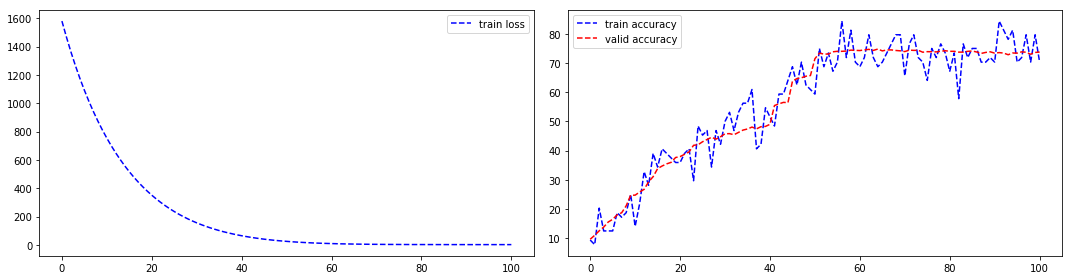

In [8]:
performance_chart(train_loss, train_acc, valid_acc)

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [9]:
small_size = 1000
indices = np.random.randint(low=0, high=train_dataset.shape[0], size=small_size)
small_train = train_dataset[indices,:]
small_labels = train_labels[indices,:]

small_train.shape,small_labels.shape

((1000, 784), (1000, 10))

In [10]:
BATCH_SIZE = 64
L1_UNITS = 512

graph = tf.Graph()

with graph.as_default():
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    X_train = tf.placeholder(np.float32, shape=(BATCH_SIZE, image_size**2))
    y_train = tf.placeholder(np.float32, shape=(BATCH_SIZE, num_labels))
    
    weights_l1 = tf.Variable(tf.truncated_normal((image_size**2, L1_UNITS), seed=120))
    bias_l1 = tf.Variable(tf.zeros((L1_UNITS)))
    
    weights_l2 = tf.Variable(tf.truncated_normal((L1_UNITS, num_labels), seed=101))
    bias_l2 = tf.Variable(tf.zeros((num_labels)))
    
    hidden_l1 = tf.matmul(X_train, weights_l1) + bias_l1
    activation_l1 = tf.nn.relu(hidden_l1)
    
    hidden_l2 = tf.matmul(activation_l1, weights_l2) + bias_l2
    activation_l2 = tf.nn.softmax(hidden_l2)
    
    trainable_parameters = tf.trainable_variables()
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_train, logits=activation_l2)) + \
                          0.01 * tf.add_n([tf.nn.l2_loss(par) for par in trainable_parameters])
    
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    train_prediction = activation_l2
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_l1) + bias_l1), weights_l2) + bias_l2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_l1) + bias_l1), weights_l2) + bias_l2)

In [11]:
num_steps = 2001

train_loss = list()
valid_acc = list()
train_acc = list()

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = (step * BATCH_SIZE) % (small_labels.shape[0] - BATCH_SIZE)
        batch_data = small_train[offset:(offset + BATCH_SIZE), :]
        batch_labels = small_labels[offset:(offset + BATCH_SIZE), :]
        
        feed_dict = {X_train: batch_data, y_train: batch_labels}
        _,l,pred = sess.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % (num_steps//100) == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            train_loss.append(l)
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            train_acc.append(accuracy(pred, batch_labels))
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 1580.512695
Minibatch loss at step 20: 1522.785156
Minibatch loss at step 40: 1467.107544
Minibatch loss at step 60: 1413.479980
Minibatch loss at step 80: 1361.783447
Minibatch loss at step 100: 1312.258545
Minibatch loss at step 120: 1264.535278
Minibatch loss at step 140: 1218.510010
Minibatch loss at step 160: 1174.205322
Minibatch loss at step 180: 1131.424316
Minibatch loss at step 200: 1090.321167
Minibatch loss at step 220: 1050.669678
Minibatch loss at step 240: 1012.354675
Minibatch loss at step 260: 975.574219
Minibatch loss at step 280: 939.969299
Minibatch loss at step 300: 905.612976
Minibatch loss at step 320: 872.639709
Minibatch loss at step 340: 840.669556
Minibatch loss at step 360: 809.901672
Minibatch loss at step 380: 780.251953
Minibatch loss at step 400: 751.585815
Minibatch loss at step 420: 724.003906
Minibatch loss at step 440: 697.375183
Minibatch loss at step 460: 671.577454
Minibatch loss at step 480: 646.756958
Minibatch loss at 

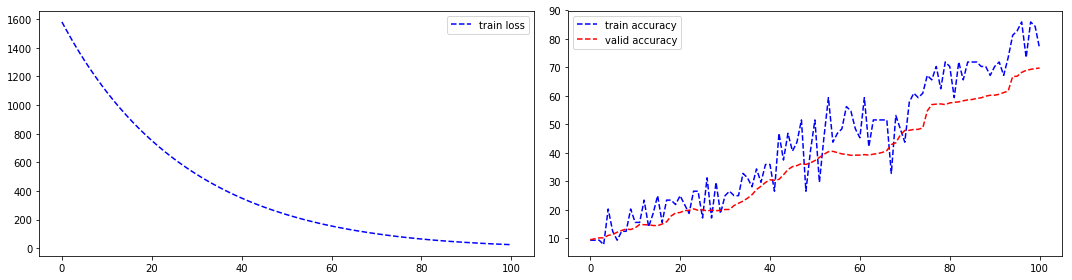

In [12]:
performance_chart(train_loss, train_acc, valid_acc)

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [16]:
BATCH_SIZE = 64
L1_UNITS = 512
DROPOUT_RATE = 0.5

graph = tf.Graph()

with graph.as_default():
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    X_train = tf.placeholder(np.float32, shape=(BATCH_SIZE, image_size**2))
    y_train = tf.placeholder(np.float32, shape=(BATCH_SIZE, num_labels))
    
    weights_l1 = tf.Variable(tf.truncated_normal((image_size**2, L1_UNITS), seed=120))
    bias_l1 = tf.Variable(tf.zeros((L1_UNITS)))
    
    weights_l2 = tf.Variable(tf.truncated_normal((L1_UNITS, num_labels), seed=101))
    bias_l2 = tf.Variable(tf.zeros((num_labels)))
    
    hidden_l1 = tf.matmul(X_train, weights_l1) + bias_l1
    dropout_l1 = tf.nn.dropout(hidden_l1, DROPOUT_RATE)
    activation_l1 = tf.nn.relu(dropout_l1)
    
    hidden_l2 = tf.matmul(activation_l1, weights_l2) + bias_l2
    activation_l2 = tf.nn.softmax(hidden_l2)
    
    trainable_parameters = tf.trainable_variables()
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_train, logits=activation_l2)) + \
                          0.01 * tf.add_n([tf.nn.l2_loss(par) for par in trainable_parameters])
    
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    train_prediction = activation_l2
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_l1) + bias_l1), weights_l2) + bias_l2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_l1) + bias_l1), weights_l2) + bias_l2)

In [17]:
num_steps = 4001

train_loss = list()
valid_acc = list()
train_acc = list()

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = (step * BATCH_SIZE) % (small_labels.shape[0] - BATCH_SIZE)
        batch_data = small_train[offset:(offset + BATCH_SIZE), :]
        batch_labels = small_labels[offset:(offset + BATCH_SIZE), :]
        
        feed_dict = {X_train: batch_data, y_train: batch_labels}
        _,l,pred = sess.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % (num_steps//100) == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            train_loss.append(l)
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            train_acc.append(accuracy(pred, batch_labels))
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 1580.482910
Minibatch loss at step 40: 1467.383179
Minibatch loss at step 80: 1362.302979
Minibatch loss at step 120: 1265.064575
Minibatch loss at step 160: 1174.899414
Minibatch loss at step 200: 1091.100098
Minibatch loss at step 240: 1013.430603
Minibatch loss at step 280: 941.183472
Minibatch loss at step 320: 873.863159
Minibatch loss at step 360: 811.327332
Minibatch loss at step 400: 753.118835
Minibatch loss at step 440: 699.003113
Minibatch loss at step 480: 648.399841
Minibatch loss at step 520: 601.438416
Minibatch loss at step 560: 557.662354
Minibatch loss at step 600: 516.879822
Minibatch loss at step 640: 478.838043
Minibatch loss at step 680: 443.494904
Minibatch loss at step 720: 410.663727
Minibatch loss at step 760: 379.966064
Minibatch loss at step 800: 351.425079
Minibatch loss at step 840: 324.894104
Minibatch loss at step 880: 300.093201
Minibatch loss at step 920: 277.246216
Minibatch loss at step 960: 255.964493
Minibatch loss at step

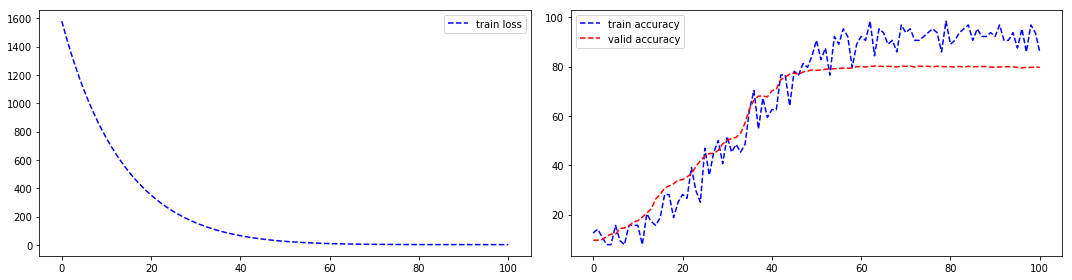

In [18]:
performance_chart(train_loss, train_acc, valid_acc)

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [19]:
BATCH_SIZE = 64
L1_UNITS = 512
L2_UNITS = 256
L3_UNITS = 64

graph = tf.Graph()

with graph.as_default():
    # set datasets for training and testing
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    X_train = tf.placeholder(np.float32, shape=(BATCH_SIZE, image_size**2))
    y_train = tf.placeholder(np.float32, shape=(BATCH_SIZE, num_labels))
    
    # initialize weights and biases
    weights_l1 = tf.Variable(tf.truncated_normal((image_size**2, L1_UNITS), seed=120))
    bias_l1 = tf.Variable(tf.zeros((L1_UNITS)))
    
    weights_l2 = tf.Variable(tf.truncated_normal((L1_UNITS, L2_UNITS), seed=101))
    bias_l2 = tf.Variable(tf.zeros((L2_UNITS)))
    
    weights_l3 = tf.Variable(tf.truncated_normal((L2_UNITS, L3_UNITS), seed=101))
    bias_l3 = tf.Variable(tf.zeros((L3_UNITS)))
    
    weights_l4 = tf.Variable(tf.truncated_normal((L3_UNITS, num_labels), seed=101))
    bias_l4 = tf.Variable(tf.zeros((num_labels)))
    
    # configure activations 
    def nn_layers(input_data):
        hidden_l1 = tf.matmul(input_data, weights_l1) + bias_l1
        activation_l1 = tf.nn.relu(hidden_l1)

        hidden_l2 = tf.matmul(activation_l1, weights_l2) + bias_l2
        activation_l2 = tf.nn.relu(hidden_l2)

        hidden_l3 = tf.matmul(activation_l2, weights_l3) + bias_l3
        activation_l3= tf.nn.relu(hidden_l3)

        hidden_l4 = tf.matmul(activation_l3, weights_l4) + bias_l4
        activation_l4 = tf.nn.softmax(hidden_l4)
        
        return activation_l4
    
    last_activation = nn_layers(X_train)
    
    # set training parameters
    trainable_parameters = tf.trainable_variables()
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_train, logits=last_activation)) + \
                          0.01 * tf.add_n([tf.nn.l2_loss(par) for par in trainable_parameters])
    
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(0.1, global_step, 50, 0.5)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step)
    
    # get prediction for train/valid/test
    train_prediction = last_activation
    valid_prediction = nn_layers(tf_valid_dataset)
    test_prediction = nn_layers(tf_test_dataset)

In [20]:
num_steps = 1001

train_loss = list()
valid_acc = list()
train_acc = list()

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
        
        feed_dict = {X_train: batch_data, y_train: batch_labels}
        _,l,pred = sess.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % (num_steps//100) == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            train_loss.append(l)
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            train_acc.append(accuracy(pred, batch_labels))
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 2129.319336
Minibatch loss at step 10: 260.976990
Minibatch loss at step 20: 52.534161
Minibatch loss at step 30: 29.277557
Minibatch loss at step 40: 14.248386
Minibatch loss at step 50: 6.430573
Minibatch loss at step 60: 3.491776
Minibatch loss at step 70: 2.711032
Minibatch loss at step 80: 2.399501
Minibatch loss at step 90: 2.365201
Minibatch loss at step 100: 2.355343
Minibatch loss at step 110: 2.220150
Minibatch loss at step 120: 2.239067
Minibatch loss at step 130: 2.219061
Minibatch loss at step 140: 2.151702
Minibatch loss at step 150: 2.169397
Minibatch loss at step 160: 2.291189
Minibatch loss at step 170: 2.205951
Minibatch loss at step 180: 2.181947
Minibatch loss at step 190: 2.197952
Minibatch loss at step 200: 2.241680
Minibatch loss at step 210: 2.219889
Minibatch loss at step 220: 2.149308
Minibatch loss at step 230: 2.177955
Minibatch loss at step 240: 2.233370
Minibatch loss at step 250: 2.236349
Minibatch loss at step 260: 2.246637
Mini

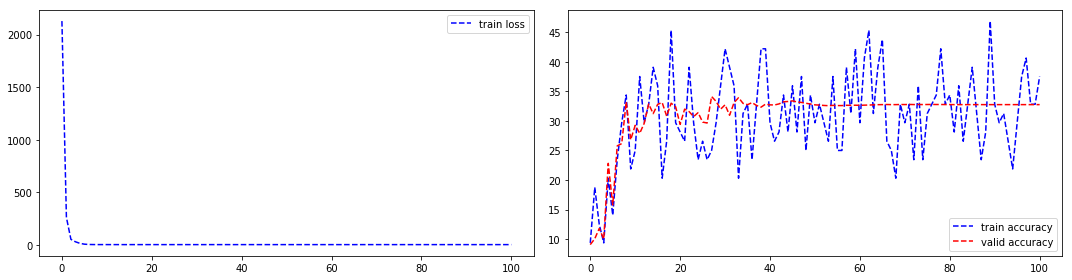

In [21]:
performance_chart(train_loss, train_acc, valid_acc)